# Digital quantification of cellular-level tau pathology using nuclei-detection-based image analysis in a progressive supranuclear palsy cohort

**Journal of Neuropathology & Experimental Neurology**

## Objective: validate and use the digital pathology pipeline for quantitative analysis of tau IHC images

1. Cross validation between Stardist and manual cell nuclei detection
2. Comparison of digital pathological quantification with pathologist-assigned scores
3. Analysis of tau burden quantified by digital pathology in several brain regions comparing with controls
4. Analysis of tau burden relation with relevance clinical information: age, gender, PSP subtype
5. Identify the proportion of intracellular tau in the overall tau burden

## Methods

![comparison](./illustrations/methods.png)

<center>Figure 1</center>

**Definition: pTau - number of positive cells divided by the number of total cells in the region**


* QuPath
* StarDist
* Bayesian linear mixed modelling

#### Load packages for analysis

In [1]:
%load_ext rpy2.ipython

C:\Users\Eric\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [4]:
import os
import os.path as op
import json
import pandas as pd
from pandas import DataFrame as DF
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pystan
from numpy import dtype
import scipy.stats as stats
from IPython.display import Markdown, display, Image
from IPython.core.display import HTML
from ipywidgets import interact, fixed
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
sns.set(font_scale=1.4)
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}



## 1. Automatic cell nuclei detection agrees with manual results

Manual vs StarDist Jaccard: 0.866
Interrater Jaccard: 0.864


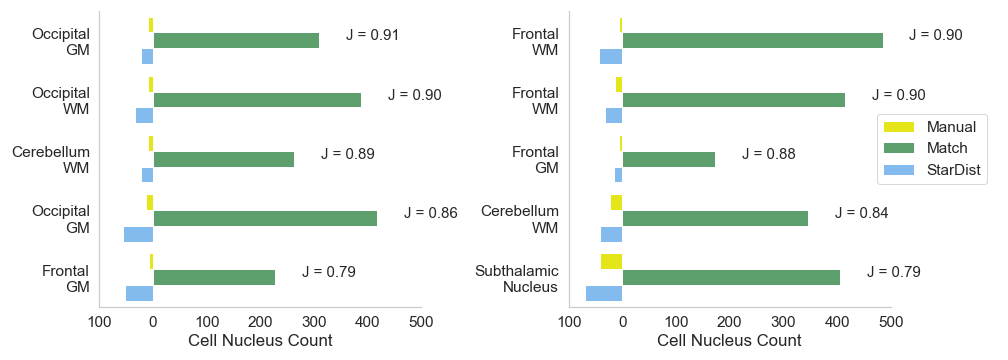

In [7]:
# Generate record of detected nuclei for both methods
pa = r"C:\Users\Eric\Dropbox (Cambridge University)\Artemisia\Kieren\Kaalund\sixth_run"
os.chdir(pa)
pa = "validation"

all_slides = []
for roots, dirs, files in os.walk(pa):
    for f in files:
        if f.endswith('_FOV.json'):
            all_slides.append(f.replace('_FOV.json', ''))

from shapely.geometry import shape, Point, Polygon

cross_vad1 = {}
P_SIZE = 0.2528

def parse_cell(s, pa):
    list_of_sanne_files = []
    list_of_eric_files = []
    
    for f in os.listdir(pa):
        if f.startswith(s) and not f.endswith('_FOV.json') and 'Eric' not in f:
            list_of_sanne_files.append(f)
        elif f.startswith(s) and 'Eric' in f:
            list_of_eric_files.append(f)
        
    list_of_cells = []
    list_of_exclcells = []  # excluded cells labelled by Sanne     
    for c in list_of_sanne_files:
        with open(op.join(pa, c)) as f:
            roi = json.load(f)
        if roi['geometry']['type'] == 'MultiPoint':
            list_of_cells += roi['geometry']['coordinates']
        elif roi['geometry']['type'] == 'Polygon':
            p = shape(roi['geometry'])
            list_of_exclcells.append(p)
    d1 = DF(np.array(list_of_cells), columns=['X', 'Y'])
    d1['certainty'] = 1
    if len(list_of_exclcells) > 0:
        for p in list_of_exclcells:
            for i, rows in d1.iterrows():
                if p.contains(Point(rows['X'], rows['Y'])):
                    d1.loc[i, 'certainty'] = 0
                    
    list_of_cells = []
    for c in list_of_eric_files:
        with open(op.join(pa, c)) as f:
            roi = json.load(f)
        if roi['geometry']['type'] == 'MultiPoint':
            list_of_cells += roi['geometry']['coordinates']

    d2 = DF(np.array(list_of_cells), columns=['X', 'Y'])
    return d1, d2
    
def filter_fov(df, s, pa):
    L = []
    with open(op.join(pa, s+'_FOV.json'), 'r') as f:
        g = json.load(f)
        fov = shape(g['geometry'])
        
    for i, rows in df.iterrows():
        if fov.contains(Point(rows['X'], rows['Y'])):
            L.append(rows)
    return DF(L)

for s in all_slides:
    d1, d2 = parse_cell(s, pa)
    
    ## Filter out cells that centroids are not in the boundary
    d1 = filter_fov(d1, s, pa)
    d2 = filter_fov(d2, s, pa)

    ## Load Stardist results
    st = pd.read_csv(op.join(pa, 'S{}_all_cells.csv'.format(s)))
    st = st[['X', 'Y']] / P_SIZE
    
    cross_vad1[s] = {'sanne_df':d1, 'eric_df':d2, 'stardist_df':st}

# Quantify the matching with Jaccard index
def calculate_neighbours(p, s, delta):
    P_SIZE = 0.2528
    delt = delta/P_SIZE
    
    flag = False
    for p1 in s:
        d = p.distance(p1)
        if d < delt:
            flag = True
            break
    if flag:
        s.remove(p1)
        return p1, s
    else:
        return False
    
def parse_cells(df1, df2):
    nn1 = []
    nn2 = []
    s1 = []
    s2 = []
    delta = 5  # 5 um defined as colocalisation
    
    for _, rows in df1.iterrows():
        s1.append(Point(rows['X'], rows['Y']))
    for _, rows in df2.iterrows():
        s2.append(Point(rows['X'], rows['Y']))
        
    for _, rows in df1.iterrows():
        r_copy = rows.copy()
        p = Point(rows['X'], rows['Y'])
        n = calculate_neighbours(p, s2, delta)
        if n:
            r_copy['coloc'], s2 = n
        else:
            r_copy['coloc'] = 'None'
        nn1.append(r_copy)
            
    for _, rows in df2.iterrows():
        r_copy = rows.copy()
        p = Point(rows['X'], rows['Y'])
        n = calculate_neighbours(p, s1, delta)
        if n:
            r_copy['coloc'], s1 = n
        else:
            r_copy['coloc'] = 'None'
        nn2.append(r_copy)
    
    return DF(nn1), DF(nn2)

cv3 = []
for sid, d in cross_vad1.items():
    result_d = {}
    certain_sanne = d['sanne_df'].copy()
    certain_sanne = certain_sanne[certain_sanne.certainty == 1]
    sanne, stardist = parse_cells(certain_sanne, d['stardist_df'])
    n_onlysanne = len(sanne[sanne.coloc == 'None'])
    n_coloc = len(sanne[sanne.coloc != 'None'])
    n_onlystardist = len(stardist[stardist.coloc == 'None'])

    result_d['Slice_ID'] = 'S{}'.format(sid)
    result_d['n_onlysanne'] = n_onlysanne
    result_d['n_coloc'] = n_coloc
    result_d['n_onlystardist'] = n_onlystardist
    result_d['Jaccard'] = n_coloc / (n_coloc + n_onlysanne + n_onlystardist)
    cv3.append(result_d)

cv3 = DF(cv3)

cvs = cv3.sum()
j = cvs.n_coloc / (cvs.n_coloc + cvs.n_onlysanne + cvs.n_onlystardist)
print('Manual vs StarDist Jaccard: {:.3f}'.format(j))

# Interrater Jaccard
cv5 = []
for sid, d in cross_vad1.items():
    result_d = {}
    certain_sanne = d['sanne_df'].copy()
    certain_sanne = certain_sanne[certain_sanne.certainty == 1]
    sanne, eric = parse_cells(certain_sanne, d['eric_df'])
    n_onlysanne = len(sanne[sanne.coloc == 'None'])
    n_coloc = len(sanne[sanne.coloc != 'None'])
    n_onlyeric = len(eric[eric.coloc == 'None'])

    result_d['Slice_ID'] = 'S{}'.format(sid)
    result_d['n_onlysanne'] = n_onlysanne
    result_d['n_coloc'] = n_coloc
    result_d['n_onlyeric'] = n_onlyeric
    result_d['Jaccard'] = n_coloc / (n_coloc + n_onlysanne + n_onlyeric)
    cv5.append(result_d)

cv5 = DF(cv5)
cvs = cv5.sum()
j = cvs.n_coloc / (cvs.n_coloc + cvs.n_onlysanne + cvs.n_onlyeric)
print('Interrater Jaccard: {:.3f}'.format(j))

# Plot the Jaccard index quantification
junban = cv3.sort_values(by='Jaccard', ascending=False)['Slice_ID'].to_list()
slice_dict = {'S747296':'Subthalamic\nNucleus',
 'S747320': 'Frontal\nGM',
 'S747352': 'Cerebellum\nWM',
 'S747376': 'Occipital\nGM',
 'S747283': 'Frontal\nGM',
 'S747874': 'Cerebellum\nWM',
 'S747831': 'Frontal\nWM',
 'S747365': 'Occipital\nWM',
 'S747310': 'Frontal\nWM',
 'S747390': 'Occipital\nGM'}
jaccard_dict = cv3[['Slice_ID','Jaccard']].set_index('Slice_ID').to_dict()['Jaccard']
match_dict = cv3[['Slice_ID','n_coloc']].set_index('Slice_ID').to_dict()['n_coloc']
method_dict = {'n_onlysanne': 'Manual', 'n_coloc':'Match', 'n_onlystardist':'StarDist'}

sns.set_style('whitegrid')
cv4 = (cv3.assign(n_onlysanne = -cv3.n_onlysanne)
        .assign(n_onlystardist = -cv3.n_onlystardist)
        .rename(columns=method_dict)
        .drop(columns='Jaccard')
        .melt(id_vars='Slice_ID', var_name='Method', value_name='Cell_count'))

method_colordict = {'Manual':'yellow', 'Match': 'g', 'StarDist': '#75bbfd'}
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i in [0, 1]:
    ax = axes[i]
    subset = [j for j in range(10) if j % 2 ==i] # divide the dataset into two columns for plotting
    od = [junban[i] for i in subset]
    sns.barplot(y='Slice_ID', x='Cell_count', hue='Method', order=od,
                data=cv4, palette = method_colordict, saturation=.8, ax=ax)
    ax.set_yticklabels(list(map(slice_dict.get, od)))
    ax.set_ylabel('')
    ax.set_xlabel('Cell Nucleus Count')
    ax.set_xlim([-100,500])
    ax.set_xticklabels([100, 0, 100, 200, 300, 400, 500])
    ax.grid(b=False)
    for y0, sid in enumerate(od):
        ax.text(match_dict[sid]+50, y0, "J = {:.2f}  ".format(jaccard_dict[sid]), fontsize=15)
    if i == 1:
        ax.legend(bbox_to_anchor=(1.3, 0.65),borderaxespad=0)
    else:
        ax.get_legend().remove()
    ax.axvline(x=0, ymin=-1, ymax=6, lw=0, c='gray')
plt.tight_layout()
sns.despine()
# try:
#     plt.savefig('illustrations/cellcount_valid.eps')
# except:
#     plt.savefig('illustrations/cellcount_valid.eps')
plt.show()

<center>Figure 2A</center>

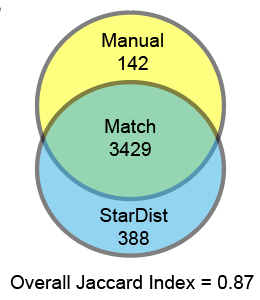

<center>Figure 2B</center>

* The error rate of StarDist automatic nuclei detection is similar to interrater variability
* StarDist always counted more cells than the human assessor, with an average overestimation of 7%

#### Validation of the automatic cell nuclei detection using StarDist.
Yellow dots - manual count. Red annotations - StarDist.

<img src="./illustrations/Figure-S1.png" alt="error" style="width: 800px;"/>

<center>SFigure 1</center>

#### Discrepancies between StarDist nuclei detection and manual counting
* (A) StarDist fails to reject artefacts
* (B) StarDist's over-segmentation (erroneously divide one nucleus into multiple ones)
* (C) StarDist's under-segmentation (fail to discern overlapping nuclei into multiple ones)
* (D) Manual counting fails to register some nuclei

<img src="./illustrations/Figure-S2.png" alt="error" style="width: 600px;"/>

<center>SFigure 2</center>

## 2. Digital pathology quantification correlates with semi-quantitative score

#### Pooled results of semi-quantitative score vs log pTau from PSP patients

Within each semi-quantitative score group, data points are ordered by increasing PSP stages assigned to the patients.

Overall Spearman correlation: 0.823


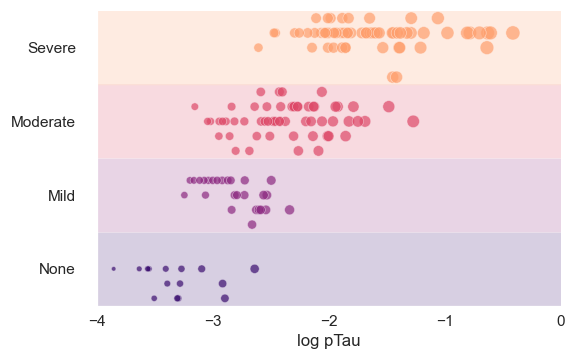

In [17]:
# link the segmentated results to anatomical regions
pa = r"C:\Users\Eric\Dropbox (Cambridge University)\Artemisia\Kieren\Kaalund\sixth_run"
os.chdir(pa)
fig_path = op.join(pa, 'figures')
if not op.isdir(fig_path):
    os.makedirs(fig_path)

patients = pd.read_excel("patients.xlsx")
metadata = pd.read_csv("slice_metadata.csv")

ptau = pd.read_csv("ptau_cell_class2.csv")
ptau = (ptau.rename(columns={'slice':'Slice_ID'})
 .merge(metadata, on='Slice_ID')
 .merge(patients, on='Patient_ID'))
ptau = ptau[(ptau.stained_protein == 'TAU') & (ptau.jufuku == 'N')]

def calc_burden(x):
    brain_region = x.region_name
    if brain_region in ['frontal', 'occipital', 'parietal', 'temporal', 'cingulate', 
                        'premo motor', 'primary motor', 'primary somatosensory']:
        if x.subregion == 'Grey_matter':
            return '{}_GM'.format(brain_region.capitalize())
        elif x.subregion == 'White_matter':
            return '{}_WM'.format(brain_region.capitalize())
        else:
            return 'Doesnt_matter'
    elif brain_region == 'cerebellum':
        if x.subregion == 'White_matter':
            return 'Cerebellum'
        else:
            return 'Doesnt_matter'
    elif brain_region == 'basal ganglia':
        if x.subregion in ['Globus Pallidus', 'Striatum', 'Subthalamic Nucleus']:
            return x.subregion
        else:
            return 'Doesnt_matter'
    elif brain_region in ['pons', 'midbrain', 'hippocampus', 'entorhinal cortex']:
        return brain_region.capitalize()
    else:
        return 'Doesnt_matter'

ptau['subregion_name'] = ptau.apply(calc_burden, axis=1)
ptau = ptau[ptau['subregion_name'] != 'Doesnt_matter']
psptau = ptau[ptau.diagnostic == 'PSP']

assessment = pd.read_csv("Pathology_assessment_and_demography.csv")
sks = assessment[['Patient_ID', 'GP_SK', 'STN_SK',
       'STR_SK', 'FCF_SK', 'DE_SK', 'OC_SK']]
sks = pd.melt(sks, id_vars=['Patient_ID'], var_name='region', value_name='SK_rating')
convert_dict = {'GP_SK':'Globus Pallidus', 
                'OC_SK':'Occipital_GM', 
                'STN_SK':'Subthalamic Nucleus', 
                'STR_SK':'Striatum', 
                'FCF_SK':'Frontal_GM', 
                'DE_SK':'Cerebellum'
               }
sks['subregion_name'] = sks['region'].map(convert_dict)
df1 = (psptau.merge(sks.drop(columns='region'), on=['Patient_ID', 'subregion_name'])
            .merge(assessment[['Patient_ID', 'Stage_SK']], on='Patient_ID'))

ho = ['Occipital_GM','Frontal_GM','Striatum', 'Cerebellum',  'Globus Pallidus',  'Subthalamic Nucleus']
df2 = df1[df1['subregion_name'].isin(ho)].copy()
df2 = df2[~df2.Stage_SK.isna()]
df2['pTau'] = df2['positive'] / (df2['positive'] + df2['negative'])
df2['logpTau'] = np.log10(df2['pTau'])
df2 = df2.sort_values(by='pTau').reset_index(drop=True)
d = {v: k+1 for k, v in dict(enumerate(ho)).items()}
df2['region_code'] = df2['subregion_name'].map(d)

# plot semi-quantitative score against log pTau
import matplotlib.patches as patches
df3 = df2.groupby(['region_code', 'Patient_ID']).mean().reset_index()
df3 = df3[~df3.SK_rating.isna()]
def calc_ichi(x):
    return x.SK_rating + (x.Stage_SK-2)*.2 + 0.1
df3 = df3.assign(ichi = df3.apply(calc_ichi, axis=1))

plt.figure(figsize=(8,5))
colour_map = sns.color_palette('magma', n_colors=4)
ax = sns.scatterplot(data=df3, x="logpTau", y='ichi', 
                hue='SK_rating', size=(df3.logpTau+6), 
                legend=False, palette=colour_map, 
                marker='o', sizes=(20, 200), alpha=.7)
ax.set_xlim([-4, 0])
ax.set_xticks([-4, -3, -2, -1, 0])
ax.set_xlabel('log pTau', labelpad=5)
ax.set_ylim([0, 4])
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticklabels(['None', 'Mild', 'Moderate', 'Severe'])
ax.set_ylabel('')
ax.tick_params(axis='y', which='major', pad=15)
ax.spines['left'].set_color('white')  
ax.spines['bottom'].set_color('white')  
ax.grid(False)
for i in range(4):
    rect = patches.Rectangle((-4, i), 4, 1.005, facecolor=colour_map[i], alpha=.2)
    ax.add_patch(rect)
sns.despine()
plt.tight_layout()
# Check Spearman correlation
from scipy.stats import spearmanr
print('Overall Spearman correlation: {:.3f}'.format(spearmanr(df3[['logpTau', 'SK_rating']])[0]))
plt.show()
# plt.savefig(op.join(pa, 'illustrations', 'path_valid.pdf'))

<center>Figure 2C</center>

#### Individual profiles (selected patients)

CBCXF - cerebellum white matter (including the dentate nucleus); F - frontal cortex grey matter; GP - globus pallidus; O - occipital cortex grey matter; STR - striatum; STN - subthalamic nucleus

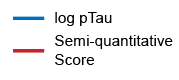

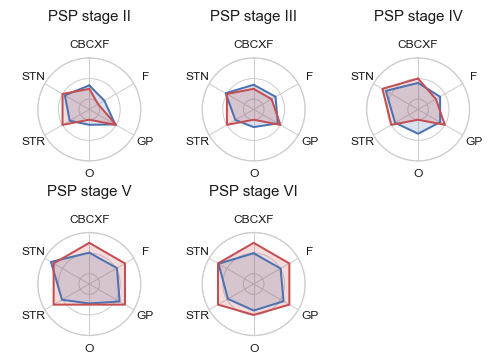

In [9]:
# generate one-to-one values of semi-quantitative score and pTau
all_size = (df1[~(df1.Stage_SK.isna() | df1.SK_rating.isna())].groupby(['Patient_ID', 'Stage_SK'])
.size().to_frame().reset_index().rename(columns={0:'saizu'}))
all_size = all_size[all_size.saizu >= 6]
selected = []
for stage, dfs in all_size.groupby('Stage_SK'):
    selected.append(dfs.sample(random_state=6))
selected = pd.concat(selected, ignore_index=True)
def fill_zeros(col):
    if col.dtype == dtype('float64'):
        avg = col[col > 0].mean()
        col2 = col.copy()
        col2[col == 0] = avg
        return col2
    else:
        return col

qp = df2.assign(log_tau_burden = lambda x: x['logpTau'] + 5)
qp = pd.pivot_table(qp, values='log_tau_burden', index='Patient_ID', columns=['subregion_name']).fillna(0).reset_index()
qp['sum'] = np.sum(qp, axis=1)
qp = qp.sort_values(by='sum', ascending=False).drop(columns=['sum']).reset_index(drop=True)
shorthand = {'Patient_ID':'Patient_ID','Cerebellum':'CBCXF', 'Globus Pallidus':'GP', 'Occipital_GM':'O', 'Frontal_GM':'F', 'Striatum':'STR', 'Subthalamic Nucleus':'STN'}
qp.columns = qp.columns.map(shorthand)
qp = qp.apply(fill_zeros, axis=0)

sk = df2.assign(adjusted_rating = lambda x: x['SK_rating'] + 1)
sk = pd.pivot_table(sk, values='adjusted_rating', index='Patient_ID', columns=['subregion_name']).fillna(0).reset_index()
sk['sum'] = np.sum(sk, axis=1)
sk = sk.sort_values(by='sum', ascending=False).drop(columns=['sum']).reset_index(drop=True)
shorthand = {'Patient_ID':'Patient_ID','Cerebellum':'CBCXF', 'Globus Pallidus':'GP', 'Occipital_GM':'O', 'Frontal_GM':'F', 'Striatum':'STR', 'Subthalamic Nucleus':'STN'}
sk.columns = sk.columns.map(shorthand)
sk = sk.apply(fill_zeros, axis=0)

 
# Plot the individual radar plots of selected patients

from math import pi

def make_spider(qp, sk, row, title):

    # number of variable
    categories=list(qp)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,3,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='k', size=12)
    ax.tick_params(axis='x', which='major', pad=0)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1,3,5], [None, None, None], color="grey", size=8)
    plt.ylim(0,5)
    

    # Ind1
    values=qp.loc[row].drop('Patient_ID').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='b', linewidth=2, linestyle='solid')
    ax.fill(angles, values, color='b', alpha=0.2)
    
    # Ind2
    values2=sk.loc[row].drop('Patient_ID').values.flatten().tolist()
    values2 += values2[:1]
    ax.plot(angles, values2, color='r', linewidth=2, linestyle='solid')
    ax.fill(angles, values2, color='r', alpha=0.2)

    # Add a title
    plt.title(title, size=15, color='k', y=1.3)

# PART 2: Apply to all individuals
# initialize the figure
plt.figure(figsize=(7, 5))
sns.set_style('whitegrid')
# Create a color palette:
# my_palette = plt.cm.get_cmap("Set2", len(df3.index))
 
# Loop to plot
selected_p = selected.Patient_ID.to_list()
q = "Patient_ID in @selected_p"
qp1 = qp.query(q).set_index('Patient_ID').reindex(selected_p).reset_index()
sk1 = sk.query(q).set_index('Patient_ID').reindex(selected_p).reset_index()
title_dict = {0:'Control', 1: 'PSP stage I', 2: 'PSP stage II', 3: 'PSP stage III', 4: 'PSP stage IV', 
              5: 'PSP stage V', 6: 'PSP stage VI'}
for row in range(0, len(selected.index)):
    make_spider(qp1, sk1, row=row, title=title_dict[selected.loc[row, 'Stage_SK']])
    
plt.tight_layout()
# plt.savefig(op.join(pa, 'illustrations', 'path_au.pdf'), transparent=True)

<center>Figure 2D</center>

#### Profiles of all patient

In cases of missing data (labelled with asterisk next to the region name), the values are imputed with the mean of the entire dataset for the corresponding anatomical region.

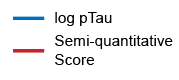

Stage 2


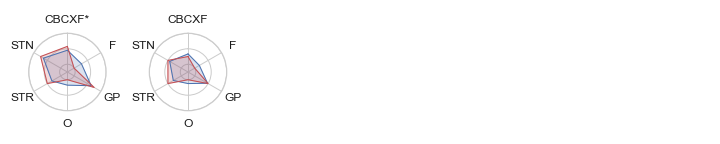

Stage 3


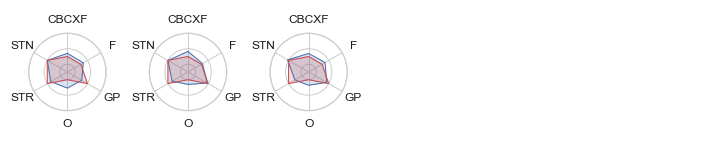

Stage 4


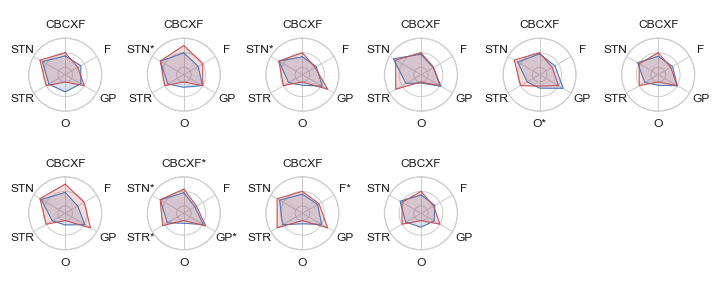

Stage 5


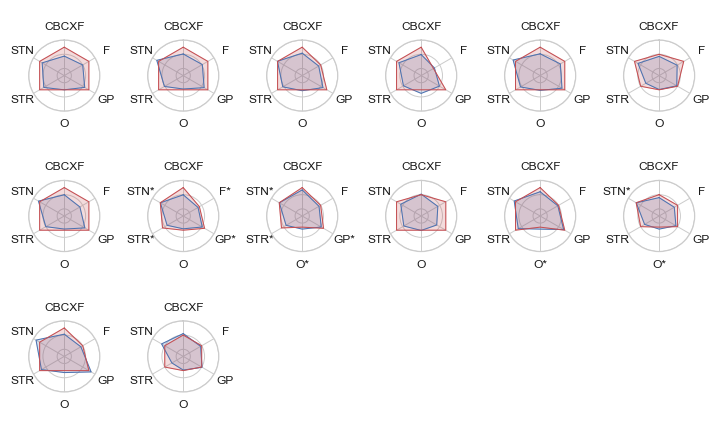

Stage 6


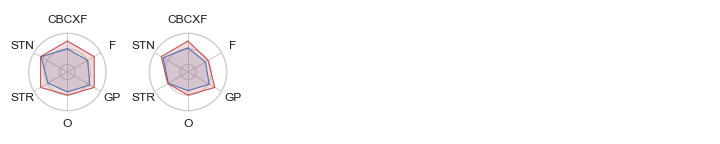

Stage Undecided


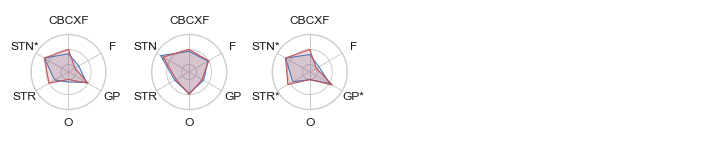

In [14]:
# Also include 
df2 = df1[df1['subregion_name'].isin(ho)].copy()
df2['pTau'] = df2['positive'] / (df2['positive'] + df2['negative'])
df2['logpTau'] = np.log10(df2['pTau'])
df2 = df2.sort_values(by='pTau').reset_index(drop=True)
d = {v: k+1 for k, v in dict(enumerate(ho)).items()}
df2['region_code'] = df2['subregion_name'].map(d)

qp = df2.assign(log_tau_burden = lambda x: x['logpTau'] + 5)
qp = pd.pivot_table(qp, values='log_tau_burden', index='Patient_ID', columns=['subregion_name']).fillna(0).reset_index()
qp['sum'] = np.sum(qp, axis=1)
qp = qp.sort_values(by='sum', ascending=False).drop(columns=['sum']).reset_index(drop=True)
shorthand = {'Patient_ID':'Patient_ID','Cerebellum':'CBCXF', 'Globus Pallidus':'GP', 'Occipital_GM':'O', 'Frontal_GM':'F', 'Striatum':'STR', 'Subthalamic Nucleus':'STN'}
qp.columns = qp.columns.map(shorthand)
qp_fill = qp.apply(fill_zeros, axis=0)

sk = df2.assign(adjusted_rating = lambda x: x['SK_rating'] + 1)
sk = pd.pivot_table(sk, values='adjusted_rating', index='Patient_ID', columns=['subregion_name']).fillna(0).reset_index()
sk['sum'] = np.sum(sk, axis=1)
sk = sk.sort_values(by='sum', ascending=False).drop(columns=['sum']).reset_index(drop=True)
sk.columns = sk.columns.map(shorthand)
sk_fill = sk.apply(fill_zeros, axis=0)

def make_spider(qp, sk, row, categories):

    # number of variable
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    rs = len(qp) // 6 + 1
    ax = plt.subplot(rs,6,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='k', size=12)
    ax.tick_params(axis='x', which='major', pad=0)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1,3,5], [None, None, None], color="grey", size=8)
    plt.ylim(0,5)
    

    # Ind1
    values=qp.loc[row].drop('Patient_ID').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='b', linewidth=1, linestyle='solid')
    ax.fill(angles, values, color='b', alpha=0.2)
    
    # Ind2
    values2=sk.loc[row].drop('Patient_ID').values.flatten().tolist()
    values2 += values2[:1]
    ax.plot(angles, values2, color='r', linewidth=1, linestyle='solid')
    ax.fill(angles, values2, color='r', alpha=0.2)

# PART 2: Apply to all individuals
# initialize the figure

sns.set_style('whitegrid')

def find_zeros(s, sym = '*'):
    return s['subregion_name']+sym if s['value'] == 0 else s['subregion_name']

# Loop to plot
df3 = df1.assign(Stage_SK = df1['Stage_SK'].fillna(9))
all_size = (df3[~df3.SK_rating.isna()].groupby(['Patient_ID', 'Stage_SK'])
.size().to_frame().reset_index().rename(columns={0:'saizu'}))
for stage, dfs in all_size.sort_values(by='Stage_SK').groupby('Stage_SK'):
    if stage == 9: print('Stage Undecided')
    else: print('Stage {:.0f}'.format(stage))
    
    selected_p = dfs.Patient_ID.to_list()
    q = "Patient_ID in @selected_p"
    qp1 = qp_fill.query(q).set_index('Patient_ID').reindex(selected_p).reset_index()
    sk1 = sk_fill.query(q).set_index('Patient_ID').reindex(selected_p).reset_index()
    rs = len(qp1) // 6 + 1
    plt.figure(figsize=(10, 2*rs))
    for row in range(0, len(selected_p)):
        # label the region name if the values were missing and filled with the mean
        qp_zeros = qp[qp.Patient_ID == selected_p[row]]
        qp_categories = (qp_zeros.set_index('Patient_ID').T
                             .reset_index()
                             .rename(columns={selected_p[row]: 'value'})
                             .apply(find_zeros, axis=1)).to_list()

        make_spider(qp1, sk1, row=row, categories=qp_categories)

    plt.tight_layout()
    plt.show()
#     plt.savefig(op.join(pa, 'illustrations', 'path_au_stage{}.pdf'.format(stage)), transparent=True)

<center>SFigure 3</center>

## 3. Digital pathology highlights brain regions with high tau burden

#### In selected regions from Kovacs staging: 
* frontal cortex (grey matter)
* occipital cortex (grey matter)
* cerebellum (white matter)
* striatum
* globus pallidus
* subthalamic nucleus

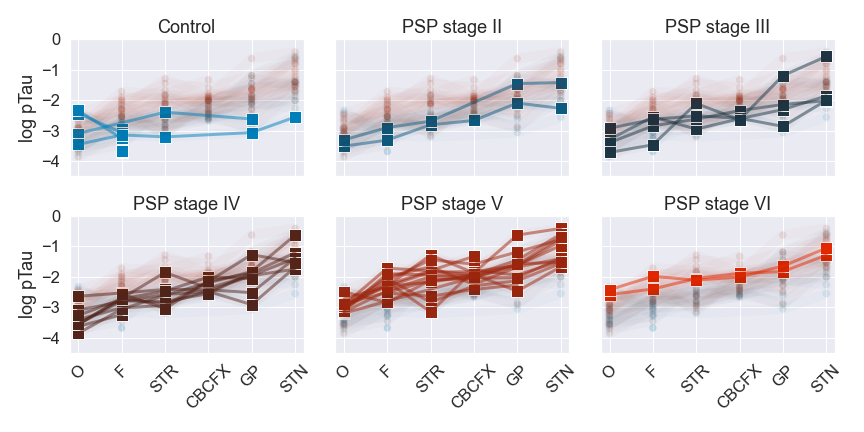

In [19]:
# link the segmentated results to anatomical regions
sns.set_style('darkgrid')
pa = r"C:\Users\Eric\Dropbox (Cambridge University)\Artemisia\Kieren\Kaalund\sixth_run"
os.chdir(pa)
fig_path = op.join(pa, 'figures')
if not op.isdir(fig_path):
    os.makedirs(fig_path)

patients = pd.read_excel("patients.xlsx")
metadata = pd.read_csv("slice_metadata.csv")

ptau = pd.read_csv("ptau_cell_class2.csv")
ptau = (ptau.rename(columns={'slice':'Slice_ID'})
 .merge(metadata, on='Slice_ID')
 .merge(patients, on='Patient_ID'))
ptau = ptau[(ptau.stained_protein == 'TAU') & (ptau.jufuku == 'N')]

def calc_burden(x):
    brain_region = x.region_name
    if brain_region in ['frontal', 'occipital', 'parietal', 'temporal', 'cingulate', 
                        'premo motor', 'primary motor', 'primary somatosensory']:
        if x.subregion == 'Grey_matter':
            return '{}_GM'.format(brain_region.capitalize())
        elif x.subregion == 'White_matter':
            return '{}_WM'.format(brain_region.capitalize())
        else:
            return 'Doesnt_matter'
    elif brain_region == 'cerebellum':
        if x.subregion == 'White_matter':
            return 'Cerebellum'
        else:
            return 'Doesnt_matter'
    elif brain_region == 'basal ganglia':
        if x.subregion in ['Globus Pallidus', 'Striatum', 'Subthalamic Nucleus']:
            return x.subregion
        else:
            return 'Doesnt_matter'
    elif brain_region in ['pons', 'midbrain', 'hippocampus', 'entorhinal cortex']:
        return brain_region.capitalize()
    else:
        return 'Doesnt_matter'

ptau['subregion_name'] = ptau.apply(calc_burden, axis=1)
ptau = ptau[ptau['subregion_name'] != 'Doesnt_matter']
psptau = ptau[ptau.diagnostic == 'PSP']
ctrltau = ptau[ptau.diagnostic == 'control']

assessment = pd.read_csv("Pathology_assessment_and_demography.csv")
sks = assessment[['Patient_ID', 'GP_SK', 'STN_SK',
       'STR_SK', 'FCF_SK', 'DE_SK', 'OC_SK']]
sks = pd.melt(sks, id_vars=['Patient_ID'], var_name='region', value_name='SK_rating')
convert_dict = {'GP_SK':'Globus Pallidus', 
                'OC_SK':'Occipital_GM', 
                'STN_SK':'Subthalamic Nucleus', 
                'STR_SK':'Striatum', 
                'FCF_SK':'Frontal_GM', 
                'DE_SK':'Cerebellum'
               }
sks['subregion_name'] = sks['region'].map(convert_dict)
df1 = (psptau.merge(sks.drop(columns='region'), on=['Patient_ID', 'subregion_name'])
            .merge(assessment[['Patient_ID', 'Stage_SK']], on='Patient_ID')
            .append(ctrltau.assign(Stage_SK = 0), ignore_index=True))

# Select the Kovacs regions
ho = ['Occipital_GM','Frontal_GM','Striatum', 'Cerebellum',  'Globus Pallidus',  'Subthalamic Nucleus']
df2 = df1[df1['subregion_name'].isin(ho)].copy()
df2 = df2[~df2.Stage_SK.isna()]
df2['pTau'] = df2['positive'] / (df2['positive'] + df2['negative'])
df2['logpTau'] = np.log10(df2['pTau'])
df2 = df2.sort_values(by='pTau').reset_index(drop=True)
d = {v: k+1 for k, v in dict(enumerate(ho)).items()}
df2['region_code'] = df2['subregion_name'].map(d)
df3 = df2.groupby(['region_code', 'Patient_ID']).mean().reset_index()

# Plot the regional distribution figure
f, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
sns.set(font_scale=1.5)
sns.set_style('darkgrid')

colour_map = sns.diverging_palette(240, 15, s=105, l=50,
                                  n=6, center="dark")
labels = ['O','F','STR', 'CBCFX',  'GP',  'STN']
title_dict = {0:'Control', 1: 'PSP stage I', 2: 'PSP stage II', 3: 'PSP stage III', 4: 'PSP stage IV', 
              5: 'PSP stage V', 6: 'PSP stage VI'}

for ax, stage, c in zip(axes.flatten(), sorted(df3.Stage_SK.unique()), colour_map):
    sns.scatterplot(data=df3,
        x="region_code", y="logpTau", hue="Stage_SK", s=45, marker='o',
        palette=colour_map, alpha=0.1, legend=False, edgecolor='grey', ax=ax)
    
    sns.scatterplot(data=df3[df3.Stage_SK == stage],
        x="region_code", y="logpTau", color=c, s=155, marker='s',
        legend=False, ax=ax)

    sns.lineplot(data=df3,
        x="region_code", y="logpTau", hue="Stage_SK", units="Patient_ID",
        estimator=None, lw=10, alpha=0.025, legend=False, palette=colour_map, ax=ax)

    sns.lineplot(data=df3[df3.Stage_SK == stage],
        x="region_code", y="logpTau", color=c, units="Patient_ID",
        estimator=None, lw=3, legend=False, alpha=0.5, ax=ax)

    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xlim([0.8, 6.2])
    ax.set_xticklabels([None]+labels, rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('log pTau')
    ax.set_ylim([-4.5, 0])
    ax.set_yticks([-4,-3,-2,-1,0])

    ax.set_title(title_dict[stage])
    
plt.tight_layout()
# plt.savefig('illustrations/kovacs.pdf')

<center>Figure 3A</center>

#### In all regions, and compare PSP group with control

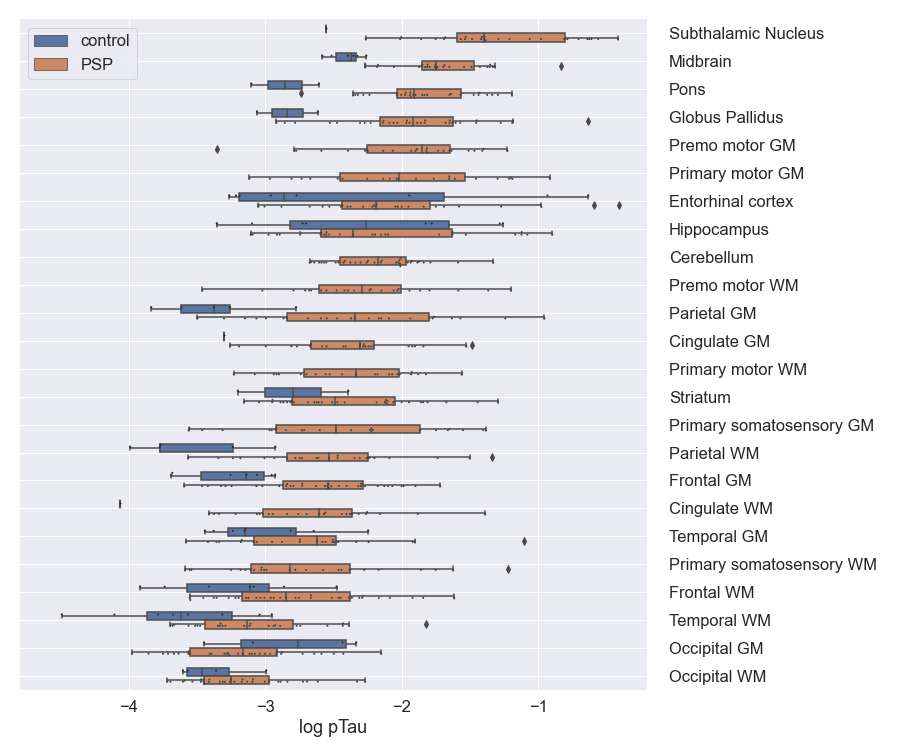

In [39]:
# calculate tau burden including control slides
df2 = psptau.copy()
df2['pTau'] = df2['positive'] / (df2['positive'] + df2['negative'])
df2['logpTau'] = np.log10(df2['pTau'])
ho = df2.groupby('subregion_name').agg({'logpTau':'median'}).sort_values(by='logpTau').index.to_list()

ctrltau['subregion_name'] = ctrltau.apply(calc_burden, axis=1)
ctrltau = ctrltau[ctrltau['subregion_name'] != 'Doesnt_matter']
df3 = ctrltau.copy()
df3['pTau'] = df3['positive'] / (df3['positive'] + df3['negative'])
df3['logpTau'] = np.log10(df3['pTau'])
df = df2.append(df3)
df.to_csv("tau_burden_PSP_R.csv", index=False)

# plot the boxplot containing grouping by regions and color coded by diagnosis
ho = df2.groupby('subregion_name').agg({'logpTau':'mean'}).sort_values(by='logpTau').index.to_list()
hueo = ['control', 'PSP']
plt.figure(figsize=(12.5, 10.5))
sns.set(font_scale=1.5)
sns.boxplot(y='subregion_name', x='logpTau', data=df, hue='diagnostic', 
            order=ho[::-1], width=.6, hue_order=hueo)
ax = sns.swarmplot(y="subregion_name", x="logpTau", hue='diagnostic', 
                   data=df, color=".25", dodge=True, order=ho[::-1], hue_order=hueo, s=2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='upper left')
plt.ylabel(None)
ax.set_xticks([-4,-3,-2,-1])
ax.set_xlim([-4.8, -0.2])
ax.set_yticklabels([item.get_text().replace('_', ' ') for item in ax.get_yticklabels()],
           ha='left', x=1.05)
plt.grid(b=True, axis='y')
plt.xlabel('log pTau')
plt.tight_layout()
sns.despine()
# plt.savefig('illustrations/all_region_ptau.eps')
plt.show()

<center>Figure 3B (left)</center>

#### Bayesian modelling of the distrbution (showing the mean and standard deviation of posterior distributions)

In [ ]:
%%R -w 2.5 -h 5 --units in -r 200 -o q
setwd("C:/Users/Eric/Dropbox (Cambridge University)/Artemisia/Kieren/Kaalund/sixth_run/")
.libPaths( "C:/Users/Eric/Documents/R/win-library/4.1" )
library(brms)
library(tidybayes)
tau <- read.csv("tau_burden_PSP_R.csv")
tau$subregion_name <- factor(tau$subregion_name, 
    levels = c('Occipital_WM',
 'Occipital_GM',
 'Temporal_WM',
 'Frontal_WM',
 'Primary somatosensory_WM',
 'Temporal_GM',
 'Cingulate_WM',
 'Frontal_GM',
 'Parietal_WM',
 'Striatum',
 'Primary somatosensory_GM',
 'Hippocampus',
 'Parietal_GM',
 'Cingulate_GM',
 'Premo motor_WM',
 'Primary motor_WM',
 'Entorhinal cortex',
 'Cerebellum',
 'Primary motor_GM',
 'Globus Pallidus',
 'Pons',
 'Premo motor_GM',
 'Midbrain',
 'Subthalamic Nucleus'))
psptau <- tau[tau$diagnostic=='PSP',]

prior1 <- c(
  prior(normal(-3, 1), class = Intercept), # Better alternatives?
  prior(normal(0, 1), class = b),
  prior(cauchy(0, .2), class = sd),
  prior(cauchy(0, .2), class = sigma)
)
fit1 <- brm(logpTau ~ subregion_name + (1|Patient_ID), 
            data = psptau,
            prior = prior1,
            warmup = 1e3,
            iter = 1.1e4,
            chains = 4, 
            cores = 4,
            seed = 1234)

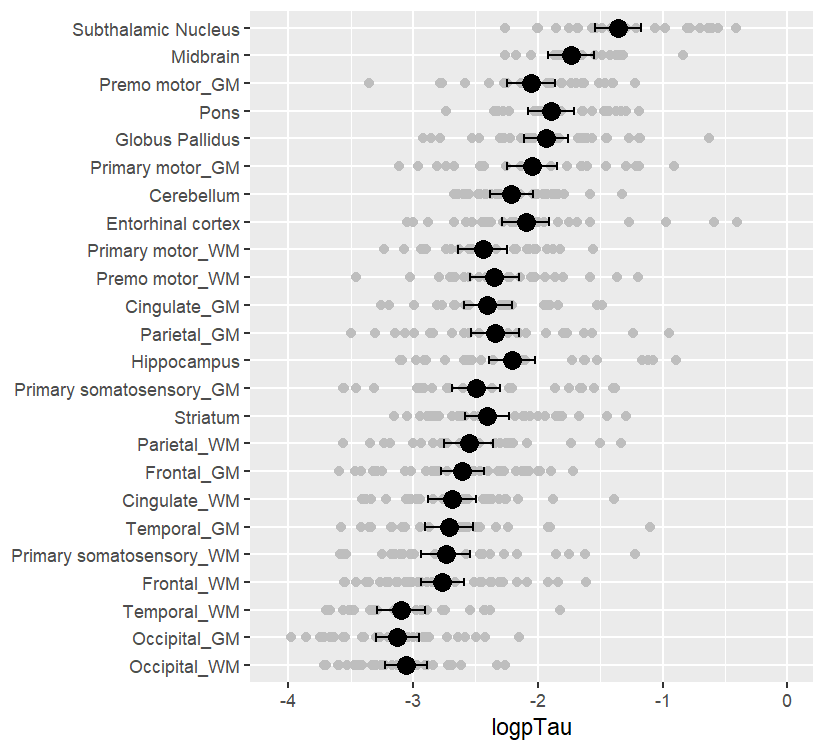

In [31]:
%%R -w 5.5 -h 5 --units in -r 150 -o q
library(ggplot2)
q <- conditional_effects(fit1, method="fitted")
# write.csv(q$subregion_name,"region_fit_R.csv", row.names = FALSE)
plot(q, plot=FALSE, points=TRUE, point_args=list(color = "Gray", size = 2))[[1]] +
ylim(-4.1,0) +
coord_flip() +
theme(axis.title.y=element_blank())

<center>Figure 3B (right)</center>

The posterior average values showed that more than 1 in 100 cells within the **subthalamic nucleus, midbrain, globus pallidus and premotor cortex grey matter** were tau positive; while less than 1 in 1000 cells within the **temporal cortex white matter, occipital cortex grey and white matter** were tau positive.

#### Identify the regions where the control is significantly different from the PSP group

Probability distribution curves of Bayesian modelled log pTau value differences between PSP and control groups (PSP-control, **delta**), grouped by anatomical regions.

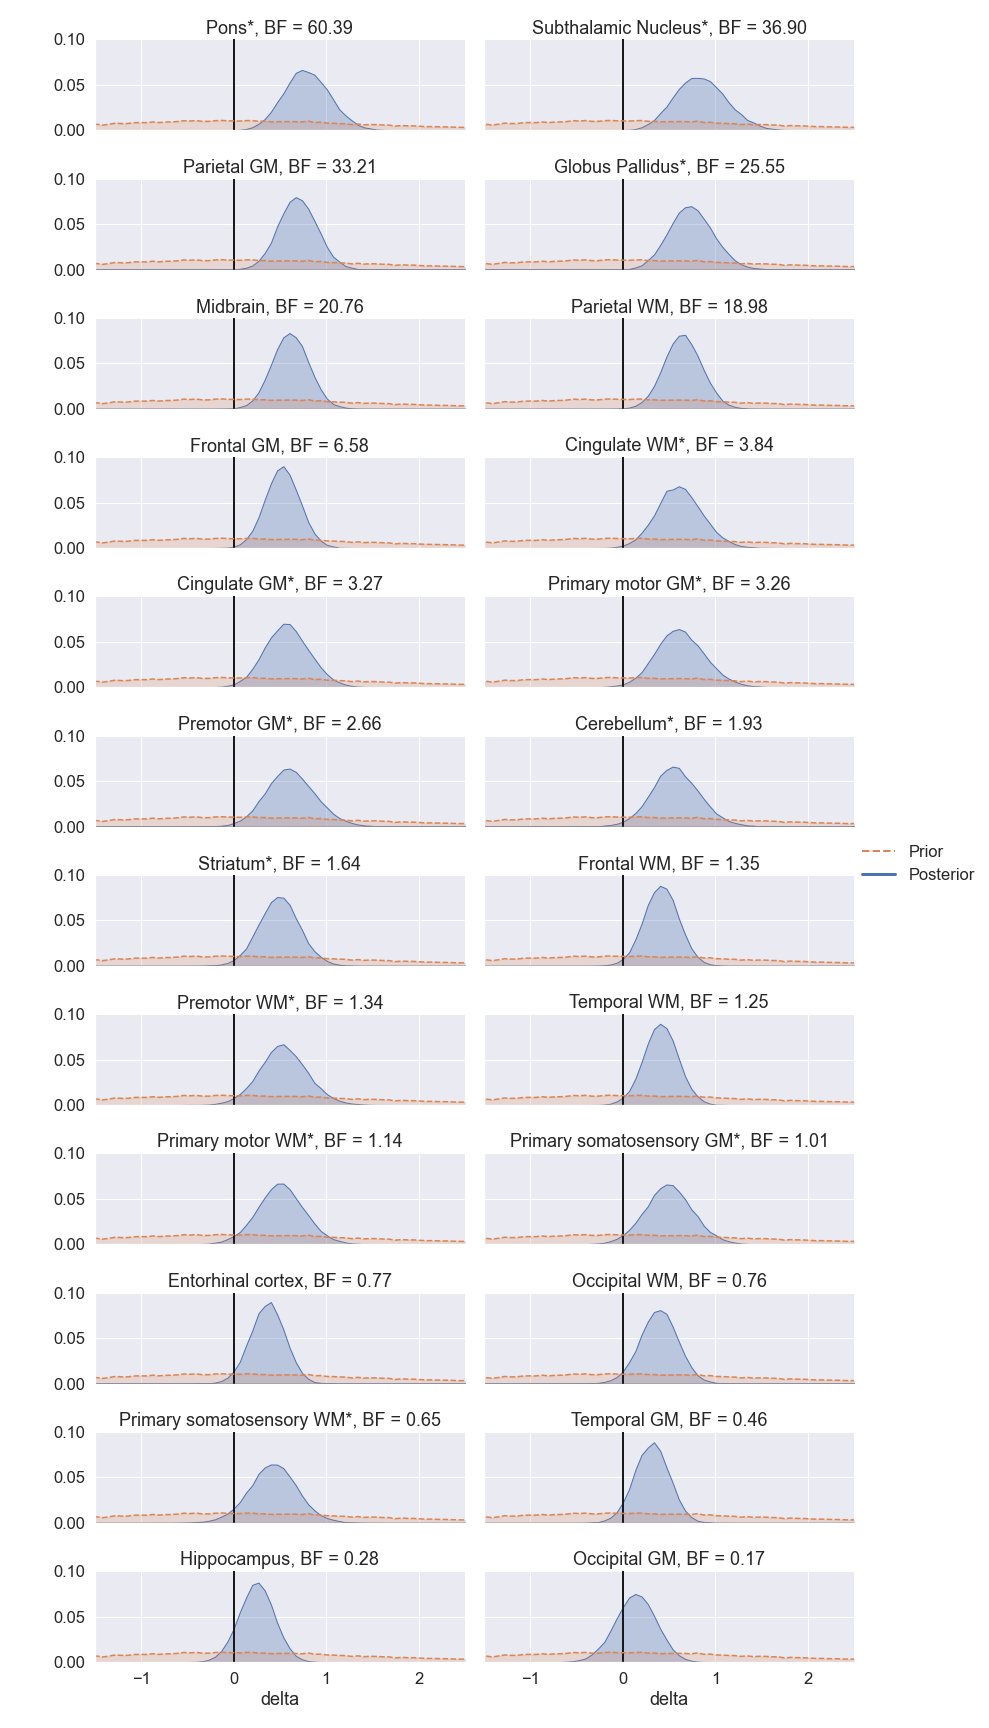

In [40]:
# Histogram precision 
pa = r"C:\Users\Eric\Dropbox (Cambridge University)\Artemisia\Kieren\Kaalund\sixth_run"
os.chdir(pa)
sns.set_style("darkgrid")
hp = np.linspace(-4,4, 120)
c1, c2 = sns.color_palette()[0:2]
df8 = (pd.pivot(pd.read_csv("posterier_test_R.csv"), index=['.chain', '.iteration', '.draw', 'subregion_name'], 
         columns=['term'])
       .reset_index()
       .droplevel(1, 1)
       .iloc[:, [3,4,6,8,9]])
df8.columns=['subregion_name','b_diagnosticPSP','b_Intercept','r_subregion_name_Intercept', 'r_subregion_name_diagnosticPSP']
df8['subregion_name'] = df8['subregion_name'].map(lambda s: s.replace('.', ' ').replace('_', ' ').replace('Premo ', 'Pre'))
df8['delta'] = df8['b_diagnosticPSP'] + df8['r_subregion_name_diagnosticPSP']

# Calculate Bayes Factor using Savage-Dickey method (ratio of density at delta = 0)
from scipy.interpolate import interp1d
def savage_dickey(prior, posterior):
    hist_dict = {'bins':hp, 'density':True}
    L = []
    for dist in [prior, posterior]:
        hist1, bins = np.histogram(dist, **hist_dict)
        bins_mid = np.array([(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])])
        f = interp1d(bins_mid, hist1)
        zero_point = f(0)
        L.append(zero_point)
    return (L[0]/L[1])

region_effect_order = ['Pons', 'Parietal GM', 'Subthalamic Nucleus', 'Globus Pallidus', 'Parietal WM', 
       'Midbrain', 'Frontal GM', 'Cingulate WM', 'Cingulate GM',
       'Premotor GM', 'Primary motor GM', 'Cerebellum', 'Striatum',
       'Premotor WM', 'Primary motor WM', 'Frontal WM', 'Temporal WM',
       'Primary somatosensory GM', 'Entorhinal cortex', 'Occipital WM',
       'Primary somatosensory WM', 'Temporal GM', 'Hippocampus',
       'Occipital GM']

# Calculate prior
from scipy.stats import halfcauchy
sample_size = 40000
hcauchy = halfcauchy.rvs(0, 2, sample_size)
b_dist = np.random.normal(0,1,sample_size) + np.array([np.random.normal(0,i) for i in hcauchy])

# Calculate Bayesian factor and determine the order
bf_dict = {}
for region in region_effect_order:
    bf = savage_dickey(b_dist, df8[df8.subregion_name == region]['delta'])
    bf_dict[region] = bf
region_effect_order = sorted(bf_dict.keys(), key=bf_dict.get)[::-1]

g = sns.displot(data=df8, x="delta", col="subregion_name", 
            fill=True, kind="hist", col_wrap=2, alpha=.3, height=2, aspect=3,
            col_order=region_effect_order, element='poly', stat='density',
            bins=hp)

# plot prior
hist_dict = {'bins':hp, 'range':(-1.5, 2.5), 'density':True}
hist1, bins = np.histogram(b_dist, **hist_dict)
bins_mid = np.array([(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])])
bf_dict = {}

for ax, region in zip(g.axes.flatten(), region_effect_order):
    bf = savage_dickey(b_dist, df8[df8.subregion_name == region]['delta'])
    bf_dict[region] = bf
    ax.set_title("{}, BF = {:.2f}".format(region, bf))
    ax.axes.set_ylabel(None)
    ax.axvline(x=0, ymin=0, ymax=1, lw=2, c='k')
    if region in ['Pons',
 'Subthalamic Nucleus',
 'Globus Pallidus',
 'Cingulate WM',
 'Cingulate GM',
 'Premotor GM',
 'Primary motor GM',
 'Cerebellum',
 'Striatum',
 'Premotor WM',
 'Primary motor WM',
 'Primary somatosensory GM',
 'Primary somatosensory WM']:
        ax.set_title("{}*, BF = {:.2f}".format(region, bf))
    sns.lineplot(y=hist1/24, x=bins_mid, color=c2, ls='--', ax=ax)
    ax.fill_between(bins_mid, hist1/24, alpha=.2, color=c2)
    ax.set_xticks([-1,0,1,2])
    ax.set_xlim(-1.5,2.5)
    ax.set_ylim(0, 0.1)

# Add legend
g.add_legend({'Prior': Line2D([0], [0], color=c2, lw=2, ls='--'), 
             'Posterior': Line2D([0], [0], color=c1, lw=3)})
plt.show()

# plt.savefig(op.join(pa, 'illustrations', 'Figure-S4.pdf'))

<center>SFigure 4</center>

Anatomical regions with control data size less than 3 are labelled with an asterisk next to the region name.

**Parietal cortex grey and white matter, midbrain and frontal cortex grey matter** were the regions where higher tau burden was observed in the PSP patients (BF > 3), and the sample size of control group >= 3

#### Visualisation of PSP and control posteriors

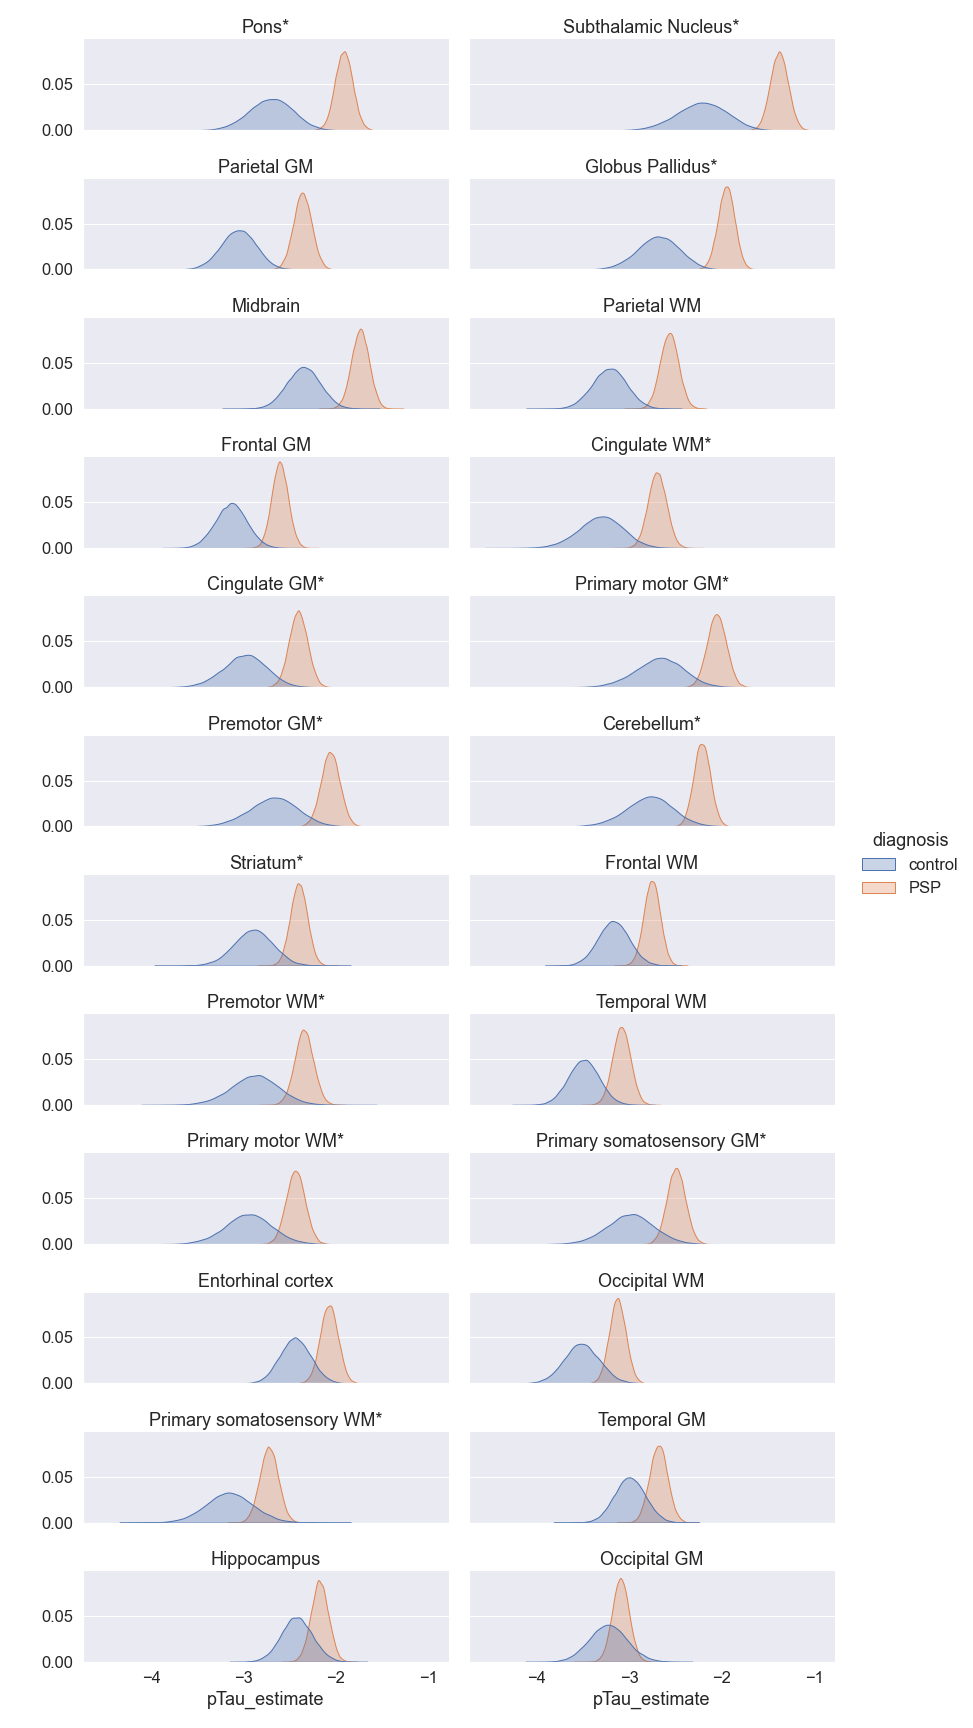

In [51]:
df9 = (pd.pivot(pd.read_csv("posterier_test_R.csv"), index=['.chain', '.iteration', '.draw', 'subregion_name'], 
         columns=['term'])
       .reset_index()
       .droplevel(1, 1)
       .iloc[:, [3,4,6,8,9]])
df9.columns=['subregion_name','b_diagnosticPSP','b_Intercept','r_subregion_name_Intercept', 'r_subregion_name_diagnosticPSP']
df9['subregion_name'] = df9['subregion_name'].map(lambda s: s.replace('.', ' ').replace('_', ' ').replace('Premo ', 'Pre'))
df9 = df9.assign(psp=0).append(df9.assign(psp=1), ignore_index=True)

df9['pTau_estimate'] = df9['b_Intercept'] + \
                       df9['r_subregion_name_Intercept'] + \
                       (df9['b_diagnosticPSP'] + df9['r_subregion_name_diagnosticPSP'])*df9['psp']
df9['diagnosis'] = df9['psp'].map(lambda x: 'PSP' if x else 'control')

# Plot distributions
g = sns.displot(data=df9, x="pTau_estimate", hue="diagnosis", col="subregion_name", 
            fill=True, kind="kde", col_wrap=2, alpha=.3, height=2, aspect=3,
            col_order=region_effect_order)
for ax, region in zip(g.axes.flatten(), region_effect_order):
    ax.set_title("{}".format(region))
    ax.axes.xaxis.grid(None)
    ax.axes.set_ylabel(None)
    if region in ['Pons',
 'Subthalamic Nucleus',
 'Globus Pallidus',
 'Cingulate WM',
 'Cingulate GM',
 'Premotor GM',
 'Primary motor GM',
 'Cerebellum',
 'Striatum',
 'Premotor WM',
 'Primary motor WM',
 'Primary somatosensory GM',
 'Primary somatosensory WM']:
        ax.set_title("{}*".format(region))
# plt.savefig('figures/bf_regions.jpg', dpi=400)
    

## 4. No effects of age, gender or PSP subgroup on tau burden

In [52]:
# Create data table combining pTau quantification and relevant clinical data
pa = r"C:\Users\Eric\Dropbox (Cambridge University)\Artemisia\Kieren\Kaalund\sixth_run"
os.chdir(pa)

fig_path = op.join(pa, 'figures')
if not op.isdir(fig_path):
    os.makedirs(fig_path)

patients = pd.read_excel("patients.xlsx")
metadata = pd.read_csv("slice_metadata.csv")

ptau = pd.read_csv("ptau_cell_class.csv")
ptau = (ptau.rename(columns={'slice':'Slice_ID'})
 .merge(metadata, on='Slice_ID')
 .merge(patients, on='Patient_ID'))
ptau = ptau[(ptau.stained_protein == 'TAU') & (ptau.jufuku == 'N')]

def calc_burden(x):
    brain_region = x.region_name
    if brain_region in ['frontal', 'occipital', 'parietal', 'temporal', 'cingulate', 
                        'premo motor', 'primary motor', 'primary somatosensory']:
        if x.subregion == 'Grey_matter':
            return '{}_GM'.format(brain_region.capitalize())
        elif x.subregion == 'White_matter':
            return '{}_WM'.format(brain_region.capitalize())
        else:
            return 'Doesnt_matter'
    elif brain_region == 'cerebellum':
        if x.subregion == 'White_matter':
            return 'Cerebellum'
        else:
            return 'Doesnt_matter'
    elif brain_region == 'basal ganglia':
        if x.subregion in ['Globus Pallidus', 'Striatum', 'Subthalamic Nucleus']:
            return x.subregion
        else:
            return 'Doesnt_matter'
    elif brain_region in ['pons', 'midbrain', 'hippocampus', 'entorhinal cortex']:
        return brain_region.capitalize()
    else:
        return 'Doesnt_matter'
    
df = ptau[ptau.diagnostic.isin(['control', 'PSP'])]
df['subregion_name'] = ptau.apply(calc_burden, axis=1)
df = df[df['subregion_name'] != 'Doesnt_matter']
df['pTau'] = df['positive'] / (df['positive'] + df['negative'])
df['logpTau'] = np.log10(df['pTau'])

assessment = pd.read_csv("Pathology_assessment_and_demography.csv")
factors = assessment[['Patient_ID', 'Stage_SK', 'Gender',
       'Age at Death', 'disease duration (years)', 'MDS-PSP last visit',
       'PSPRS Total (last assesment)', 'ACE-R last assesment',
       'imputed ACER at average', 'imputed PSPRS at death_average']]

def create_group(x):
    if x == 'PSP-RS':
        return x
    elif x in ['PSP-CBS', 'PSP-F', 'PSP-SL']:
        return 'PSP-cortical'
    else:
        return 'PSP-subcortical'
df2 = df.merge(factors, on='Patient_ID')
df2['subgroup'] = df2['MDS-PSP last visit'].str.split('. ', expand=True)[1]
df2['subgroup'] = df2['subgroup'].map(create_group)
df2.to_csv("multi_assessment_R.csv", index=False)


Use `bayes_factor` to calculate marginal likelihood

#### Examine the effect of age at death on log pTau

In [53]:
%%R -o s1,s2,s3
setwd("C:/Users/Eric/Dropbox (Cambridge University)/Artemisia/Kieren/Kaalund/sixth_run/")
.libPaths( "C:/Users/Eric/Documents/R/win-library/4.1" )
library(brms)
library(tidybayes)
tau2 <- read.csv("multi_assessment_R.csv")
prior2 <- c(
  prior(normal(-3, 1), class = Intercept),
  prior(normal(0, 1), class = b),
  prior(cauchy(0, 2), class = sd),
  prior(cauchy(0, 2), class = sigma)
)

# model with all factors
fit5.1.3 <- brm(logpTau ~ diagnostic + (1 | subregion_name) + Age.at.Death + Gender + (1|Patient_ID), 
              data = tau2,
              prior = prior2,
              warmup = 3e3,
              iter = 1.3e4,
              chains = 4, 
              cores = 4,
              seed = 1234,
              save_all_pars = T)

# model with all factors except age at death
fit5.1.4 <- brm(logpTau ~ diagnostic + (1 | subregion_name) + Gender + (1|Patient_ID), 
              data = tau2,
              prior = prior2,
              warmup = 3e3,
              iter = 1.3e4,
              chains = 4, 
              cores = 4,
              seed = 1234,
              save_all_pars = T)

s1 <- bayes_factor(fit5.1.3, fit5.1.4)
s2 <- bayes_factor(fit5.1.3, fit5.1.4)
s3 <- bayes_factor(fit5.1.3, fit5.1.4)


In [27]:
for (_, v1), (_, v2), (_, v3) in zip(s1.items(), s2.items(), s3.items()):
    print('BF: {}'.format(np.asarray([v1,v2,v3]).flatten()))
    break

BF: [0.01724653 0.01761726 0.01731256]


Bayes factor suggests very strong evidence (BF = 0.017, mean of 3 runs) of the null hypothesis: Age at death has no effects on log pTau

#### Examine the effect of gender at death on log pTau

In [29]:
%%R -o s1,s2,s3

fit5.1.5 <- brm(logpTau ~ diagnostic + (1 | subregion_name) + Age.at.Death + (1|Patient_ID), 
              data = tau2,
              prior = prior2,
              warmup = 3e3,
              iter = 1.3e4,
              chains = 4, 
              cores = 4,
              seed = 1234,
              save_all_pars = T)

s1 <- bayes_factor(fit5.1.3, fit5.1.5)
s2 <- bayes_factor(fit5.1.3, fit5.1.5)
s3 <- bayes_factor(fit5.1.3, fit5.1.5)


In [30]:
for (_, v1), (_, v2), (_, v3) in zip(s1.items(), s2.items(), s3.items()):
    print('BF: {}'.format(np.asarray([v1,v2,v3]).flatten()))
    break

BF: [0.16826736 0.16720966 0.16910652]


Bayes factor suggests moderate evidence (BF = 0.17, mean of 3 runs) of the null hypothesis: Gender has no effects on log pTau

#### Use Savage-Dickey method to check inter-group (male vs female) differences

In [14]:
%%R
fit5.2 <- brm(logpTau ~ diagnostic*Gender + (diagnostic||subregion_name) + Age.at.Death + (1|Patient_ID), 
              data = tau2,
              prior = prior2,
              warmup = 3e3,
              iter = 1.3e4,
              chains = 4, 
              cores = 4,
              seed = 1234)
pt <- spread_draws(fit5.2, b_GenderMale, `b_diagnosticPSP:GenderMale`,  b_Intercept)
write.csv(pt, "posterier_PSPgender_R.csv", row.names = F)

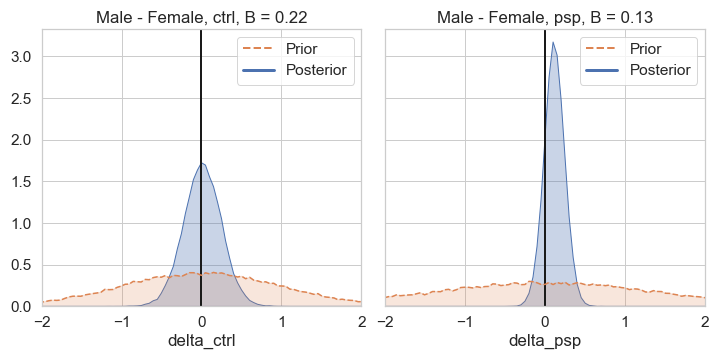

In [17]:
sns.set_style('whitegrid')
c1, c2 = sns.color_palette()[0:2]
df8 = pd.read_csv("posterier_PSPgender_R.csv")
df8['delta_ctrl'] = df8['b_GenderMale']
df8['delta_psp'] = df8['b_GenderMale'] + df8['b_diagnosticPSP:GenderMale']
bins_spec = np.linspace(-5,5,200)

f, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

for delta, ax in zip(['delta_ctrl', 'delta_psp'], axes):
    g = sns.histplot(data=df8, x=delta, ax=ax,
                fill=True, alpha=.3, 
                element='poly', stat='density',
                bins=bins_spec)

    sample_size = 40000
    if delta == 'delta_ctrl':
        b_dist = np.random.normal(0,1,sample_size)
    else:
        b_dist = np.random.normal(0,1,sample_size) + np.random.normal(0,1,sample_size)
        
    # Define Savage-Dickey function
    def savage_dickey(prior, posterior):
        hist_dict = {'bins':bins_spec, 'density':True}
        L = []
        for dist in [prior, posterior]:
            hist1, bins = np.histogram(dist, **hist_dict)
            bins_mid = np.array([(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])])
            f = interp1d(bins_mid, hist1)
            zero_point = f(0)
            L.append(zero_point)
        return (L[0]/L[1])


    # plot prior
    hist_dict = {'bins':bins_spec, 'range':(-1.5, 2.5), 'density':True}
    hist1, bins = np.histogram(b_dist, **hist_dict)
    bins_mid = np.array([(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])])
    bf = savage_dickey(b_dist, df8[delta])
    ax.set_title("Male - Female, {}, B = {:.2f}".format(delta.replace('delta_', ''), bf))
    ax.axes.set_ylabel(None)
    ax.axvline(x=0, ymin=0, ymax=1, lw=2, c='k')
    ax.legend(labels = ['Prior', 'Posterior'], 
              handles = [Line2D([0], [0], color=c2, lw=2, ls='--'), 
               Line2D([0], [0], color=c1, lw=3)])

    sns.lineplot(y=hist1, x=bins_mid, color=c2, ls='--', ax=ax)
    ax.fill_between(bins_mid, hist1, alpha=.2, color=c2)
    ax.set_xticks([-2,-1, 0 ,1, 2])
    ax.set_xlim(-2,2)
    # ax.set_ylim(0, 1)

plt.tight_layout()


* relatively small number of subjects

#### Examine the effect of PSP subtype (PSP-RS, PSP-cortical and PSP-subcortical) on pTau

In [31]:
%%R -o s1,s2,s3
setwd("C:/Users/Eric/Dropbox (Cambridge University)/Artemisia/Kieren/Kaalund/sixth_run/")
.libPaths( "C:/Users/Eric/Documents/R/win-library/4.1" )
library(brms)
library(tidybayes)
tau2 <- read.csv("multi_assessment_R.csv")
tau2$subgroup <- relevel(factor(tau2$subgroup), ref="PSP-RS")

psptau2 <- tau2[tau2$diagnostic=='PSP',]
ctrltau2 <- tau2[tau2$diagnostic=='control',]

prior3 <- c(
  prior(normal(-3, 1), class = Intercept),
  prior(normal(0, 1), class = b),
  prior(cauchy(0, 2), class = sd),
  prior(cauchy(0, 2), class = sigma)
)

fit6.1.4 <- brm(logpTau ~ subgroup + (1|subregion_name) + Age.at.Death + Gender + (1|Patient_ID), 
              data = psptau2,
              prior = prior3,
              warmup = 3e3,
              iter = 1.3e4,
              chains = 4, 
              cores = 4,
              seed = 1234,
              save_all_pars = T)

fit6.1.5 <- brm(logpTau ~ (1|subregion_name) + Age.at.Death + Gender + (1|Patient_ID), 
              data = psptau2,
              prior = prior3,
              warmup = 3e3,
              iter = 1.3e4,
              chains = 4, 
              cores = 4,
              seed = 1234,
              save_all_pars = T)

s1 <- bayes_factor(fit6.1.4, fit6.1.5)
s2 <- bayes_factor(fit6.1.4, fit6.1.5)
s3 <- bayes_factor(fit6.1.4, fit6.1.5)

In [32]:
for (_, v1), (_, v2), (_, v3) in zip(s1.items(), s2.items(), s3.items()):
    print('BF: {}'.format(np.asarray([v1,v2,v3]).flatten()))
    break

BF: [0.2392893  0.23563581 0.23333844]


Bayes factor suggests moderate evidence (BF = 0.24, mean of 3 runs) of the null hypothesis: PSP subtype has no effects on log pTau

* Unbalanced number of subjects from each PSP subtypes

In [58]:
df = pd.read_csv("multi_assessment_R.csv")
df = df.groupby(['Patient_ID', 'subgroup', 'diagnostic']).size().reset_index().drop(columns=0)
pd.crosstab(df['subgroup'], df['diagnostic'])['PSP']

subgroup
PSP-RS             23
PSP-cortical        8
PSP-subcortical     2
Name: PSP, dtype: int64

symptom duration (year)

## 5. Digital pathology quantifies proportion of intracellular tau burden

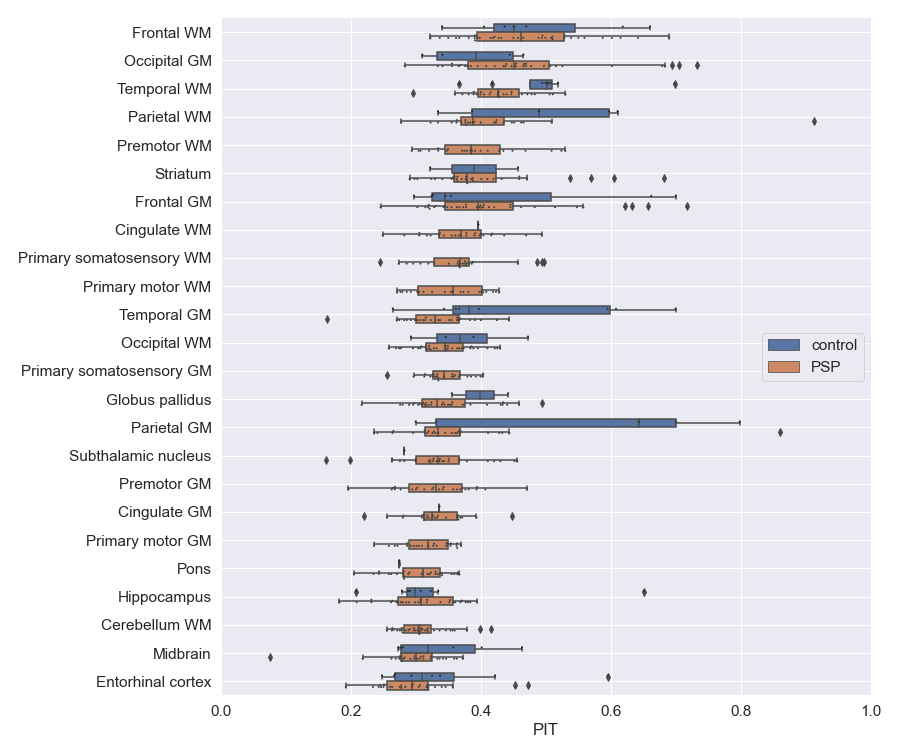

In [60]:
# Calculate proportion of intracellular tau burden (PIT) in all segemented regions
def fix_column_name(s):
    sfixed = s
    to_fix = [': ',':',' ', '/', '^', '.']
    for f in to_fix:
        if f in s:
            sfixed = sfixed.replace(f, '_')
    sfixed = ''.join([i if ord(i) < 128 else 'u' for i in sfixed])
    sfixed = sfixed.replace('uum', 'um')
    return sfixed       

def convert(r):
    convert_dict = {'Stroma': 'Grey_matter', 'Tumor': 'White_matter', 'Immune cells':'Grey_matter_Granular', 
                   'GP':'Globus Pallidus', 'STR':'Striatum', 'STN':'Subthalamic Nucleus'}
    convert_dict = {v:k for k, v in convert_dict.items()}
    try:
        return convert_dict[r]
    except:
        return r

pa = r"C:\Users\Eric\Dropbox (Cambridge University)\Artemisia\Kieren\Kaalund\tau_stains"
L = []
for f in os.listdir(pa):
    if f.endswith('_all.txt'):
        L.append(f.replace('_all.txt', ''))

all_tau = []
i = 0
for s in L:
    sid = 'S{}'.format(s)
    
    cell_pa = op.join(pa, '{}_cells.txt'.format(s))
    annot_pa = op.join(pa, '{}_all.txt'.format(s))
    
    cells = pd.read_csv(cell_pa,  sep='\t').rename(columns=fix_column_name)
    df1 = cells[~cells.duplicated(subset=['Centroid_X_um', 'Centroid_Y_um'])] # cells that are not duplicated
    try:
        soma_dict = df1.groupby('Name')['tau_Necrosis_area_um_2'].sum().to_dict()
        all_regions = soma_dict.keys()
        soma_dict = {'{}_somatic_tau_area'.format(k): v for k, v in soma_dict.items()}
        soma_dict['All_somatic_tau_area'] = sum(soma_dict.values())
    except:
        print('Error in soma {}'.format(sid))
        soma_dict = {}

    annots = pd.read_csv(annot_pa,  sep='\t').rename(columns=fix_column_name)
    tau_dict = {}

    try:
        df2 = annots[annots['Name'] == 'PathAnnotationObject'].copy().reset_index(drop=True)
        tau_dict['All_tau_area'] = df2.loc[0, 'tau_Necrosis_area_um_2']
        tau_dict['All_area'] = df2.loc[0, 'Area_um_2']
    except:
        print('Error in all tau {}'.format(sid))
        tau_dict['All_tau_area'] = 0
    for r in all_regions:
        try:
            df2 = annots[annots['Name'] == convert(r)].copy().reset_index(drop=True)
            tau_dict['{}_tau_area'.format(r)] = df2.loc[0, 'tau_Necrosis_area_um_2']
        except:
#             print('Error in all tau {}, {}'.format(sid, r))
            tau_dict['{}_tau_area'.format(r)] = 0
        try:
            tau_dict['{}_region_area'.format(r)] = df2.loc[0, 'Area_um_2']
        except:
#             print('Error in all tau {}, {}'.format(sid, r))
            tau_dict['{}_region_area'.format(r)] = 0
    
    all_tau.append({'Slice_ID':sid, **soma_dict, **tau_dict})
    i += 1
#     if i> 10: break

all_tau = DF(all_tau)

pa = r"C:\Users\Eric\Dropbox (Cambridge University)\Artemisia\Kieren\Kaalund\sixth_run"
os.chdir(pa)
slice_metadata = pd.read_csv("slice_metadata.csv")
patients = pd.read_excel("patients.xlsx")

all_tau = (all_tau.rename(columns={'slice':'Slice_ID'})
            .merge(slice_metadata, on='Slice_ID')
            .merge(patients, on='Patient_ID'))
all_tau = all_tau[(all_tau.stained_protein == 'TAU') & (all_tau.jufuku == 'N')]

# fix region names
def group_name_fix(s):
    d = {'entorhinal cortex':'Entorhinal cortex',
         'cingulate':'Cingulate',
         'occipital':'Occipital',
         'primary somatosensory': 'Primary somatosensory',
         'primary motor': 'Primary motor',
         'premo motor': 'Premotor',
         'basal ganglia': 'Basal ganglia',
         'Globus Pallidus': 'Globus pallidus',
         'Subthalamic Nucleus': 'Subthalamic nucleus'
        }
    try:
        return d[s]
    except KeyError:
        return s.title()

df4 = all_tau[all_tau['diagnostic'].isin(['PSP', 'control'])].copy()
# df['diagnostic'] = df['diagnostic'].map(shorthand_disease)
df4['region_group'] = df4['region_name'].map(group_name_fix)
df4['all_tau_ratio'] = df4['All_tau_area'] / df4['All_area']
df4['somatic_ratio'] = df4['All_somatic_tau_area'] / df4['All_tau_area']
for sr in ['White_matter', 'Grey_matter', 'Globus Pallidus', 'Subthalamic Nucleus', 'Striatum']:
    df4['{}_somatic_ratio'.format(sr)] = df4['{}_somatic_tau_area'.format(sr)] / df4['{}_tau_area'.format(sr)]
    df4['{}_tau_burden'.format(sr)] = df4['{}_tau_area'.format(sr)] / df4['{}_region_area'.format(sr)]
    
def add_matter(region, matter):
    if 'Grey_matter' in matter:
        return region+' GM'
    elif 'White_matter' in matter:
        return region+' WM'
    else: return group_name_fix(matter)

def annot_matter(subregion):
    if 'GM' in subregion:
        return 'grey'
    elif 'WM' in subregion and subregion != 'Cerebellum WM':
        return 'white'
    else:
        return 'NA'

L = []
for sr in ['White_matter', 'Grey_matter', 'Globus Pallidus', 'Subthalamic Nucleus', 'Striatum']:
    sr_col = '{}_somatic_ratio'.format(sr)
    s = df4[~df4[sr_col].isna()].assign(
        subregion_name = df4['region_group'].apply(lambda x: add_matter(x, sr)))
    s['regional_somatic_ratio'] = s[sr_col]
    s['regional_tau_burden'] = s['{}_tau_burden'.format(sr)]
    L.append(s)
    
# Add unsegmented regions
s = df4[df4.region_group.isin(['Midbrain', 'Pons', 'Entorhinal cortex', 'Hippocampus'])].copy()
s['subregion_name'] = s['region_group']
s['regional_somatic_ratio'] = s['somatic_ratio']
s['regional_tau_burden'] = s['all_tau_ratio']
L.append(s)

df5 = pd.concat(L)
df5 = df5[~df5.subregion_name.isin(
    ['Cerebellum GM', 'Hippocampus GM', 'Hippocampus WM', 'Entorhinal cortex GM', 'Entorhinal cortex WM'])].dropna(axis=1)
df5['cortical_seg'] = df5['subregion_name'].apply(annot_matter)

# Plot boxplot of PIT grouped by regions and color-coded by diagnosis group
ho = df5.groupby('subregion_name').agg({'regional_somatic_ratio':'median'}).sort_values(by='regional_somatic_ratio').index.to_list()
hueo = ['control', 'PSP']
plt.figure(figsize=(12.5, 10.5))
sns.set(font_scale=1.4)
sns.boxplot(y='subregion_name', x='regional_somatic_ratio', data=df5, hue='diagnostic', 
            order=ho[::-1], width=.6, hue_order=hueo)
ax = sns.swarmplot(y="subregion_name", x="regional_somatic_ratio", hue='diagnostic', 
                   data=df5, color=".25", dodge=True, order=ho[::-1], hue_order=hueo, s=2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc='center right')
plt.ylabel(None)
ax.set_xticks([0, 0.2, 0.4,0.6, 0.8, 1])
ax.set_xlim([0, 1])
ax.set_yticklabels([item.get_text().replace('Premo Motor', 'Premotor') for item in ax.get_yticklabels()])
plt.grid(b=True, axis='y')
plt.xlabel('PIT')
plt.tight_layout()
sns.despine()
# plt.savefig('illustrations/all_region_pit.eps')
plt.show()

<center>SFigure 5A</center>

In [68]:
print('Mean porportion of intracellular tau: {:.3f}'.format(df5.regional_somatic_ratio.describe()['mean']))

Mean porportion of intracellular tau: 0.368


`somatic tau` `cell body`

* Only slightly over one third of the tau stain was quantified by our approach, however we learnt from the above results that pTau has a high correlation with semi-quantitative score. This indicates that the key pathological changes of tau burden were largely captured by focusing on the intracellular component.

#### Examine the effect of brain region on PIT

In [61]:
%%R -o s1,s2,s3
setwd("C:/Users/Eric/Dropbox (Cambridge University)/Artemisia/Kieren/Kaalund/sixth_run/")
.libPaths( "C:/Users/Eric/Documents/R/win-library/4.1" )
library(brms)
library(tidybayes)
library(ggplot2)
stain <- read.csv("tau_stain_R.csv")

prior1 <- c(
  prior(uniform(0,1), class = Intercept), # Better alternatives?
  prior(normal(0, 1), class = b),
  prior(cauchy(0, .2), class = sd),
  prior(cauchy(0, .2), class = sigma)
)

prior2 <- c(
  prior(uniform(0,1), class = Intercept), # Better alternatives?
  prior(cauchy(0, .2), class = sd),
  prior(cauchy(0, .2), class = sigma)
)

# model with all factors
fit8 <- brm(regional_somatic_ratio ~ log_regional_tau_burden + (1|subregion_name)
              + diagnostic + (1|Patient_ID), 
            data = stain,
            prior = prior1,
            warmup = 1e3,
            iter = 1.1e4,
            chains = 4, 
            cores = 4,
            seed = 1234,
            save_all_pars = T)

# model with all factors except regions
fit8.1 <- brm(regional_somatic_ratio ~ log_regional_tau_burden
              + diagnostic + (1|Patient_ID), 
            data = stain,
            prior = prior1,
            warmup = 1e3,
            iter = 1.1e4,
            chains = 4, 
            cores = 4,
            seed = 1234,
            save_all_pars = T)

s1 <- bayes_factor(fit8, fit8.1)
s2 <- bayes_factor(fit8, fit8.1)
s3 <- bayes_factor(fit8, fit8.1)

In [62]:
for (_, v1), (_, v2), (_, v3) in zip(s1.items(), s2.items(), s3.items()):
    print('BF: {}'.format(np.asarray([v1,v2,v3]).flatten()))
    break

BF: [5.30983258e+68 5.29971813e+68 5.22731044e+68]


Bayes factor suggests extremely strong evidence (BF > 1000, mean of 3 runs) of the alternative hypothesis: brain anatomical region has an effect on PIT

#### Examine the effect of diagnosis group (PSP or control) on PIT

In [74]:
%%R -o s1,s2,s3
fit8.2 <- brm(regional_somatic_ratio ~ log_regional_tau_burden
              + (1|subregion_name)  + (1|Patient_ID), 
            data = stain,
            prior = prior1,
            warmup = 1e3,
            iter = 1.1e4,
            chains = 4, 
            cores = 4,
            seed = 1234,
            save_all_pars = T)
s1 <- bayes_factor(fit8, fit8.2)
s2 <- bayes_factor(fit8, fit8.2)
s3 <- bayes_factor(fit8, fit8.2)

In [75]:
for (_, v1), (_, v2), (_, v3) in zip(s1.items(), s2.items(), s3.items()):
    print('BF: {}'.format(np.asarray([v1,v2,v3]).flatten()))
    break

BF: [0.08136352 0.0794514  0.08325862]


Bayes factor suggests strong evidence (BF = 0.081, mean of 3 runs) of the null hypothesis: diagnosis group has no effect on PIT

#### Examine whether PIT differs in grey/white matter of cortical regions

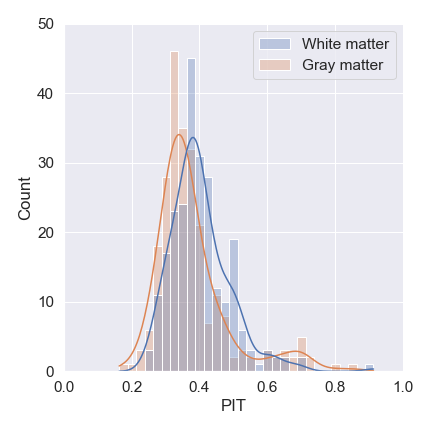

In [70]:
plt.figure(figsize=(6,6))
sns.set(font_scale=1.4)
df6 = df5[df5.cortical_seg.isin(['white', 'grey'])]
df6.to_csv('cortical_tau_stain_R.csv', index=False)
ax = sns.histplot(data=df6, x="regional_somatic_ratio", hue="cortical_seg", kde=True, alpha=0.3)
legend = ax.get_legend()
handles = legend.legendHandles
labels = ['White matter', 'Gray matter']
ax.legend(handles, labels, loc='upper right')
plt.ylim([0,50])
plt.xlim([0,1])
plt.xlabel('PIT')
plt.tight_layout()
sns.despine()
# plt.savefig('illustrations/pit_white_grey.pdf')

<center>SFigure 5B</center>

In [71]:
%%R -o s1,s2,s3
cortstain <- stain[!is.na(stain$cortical_seg),]
fit9 <- brm(regional_somatic_ratio ~ log_regional_tau_burden
            + (1|subregion_name) + cortical_seg + (1|Patient_ID), 
            data = cortstain,
            prior = prior1,
            warmup = 1e3,
            iter = 1.1e4,
            chains = 4, 
            cores = 4,
            seed = 1234,
            save_all_pars = T)

fit9.1 <- brm(regional_somatic_ratio ~ log_regional_tau_burden
            + (1|subregion_name) + (1|Patient_ID), 
            data = cortstain,
            prior = prior1,
            warmup = 1e3,
            iter = 1.1e4,
            chains = 4, 
            cores = 4,
            seed = 1234,
            save_all_pars = T)

s1 <- bayes_factor(fit9, fit9.1)
s2 <- bayes_factor(fit9, fit9.1)
s3 <- bayes_factor(fit9, fit9.1)

In [72]:
for (_, v1), (_, v2), (_, v3) in zip(s1.items(), s2.items(), s3.items()):
    print('BF: {}'.format(np.asarray([v1,v2,v3]).flatten()))
    break

BF: [1.96925972 2.03660532 1.97121476]


Bayes factor suggests neither evidence of the null or alternative hypothesis (BF = 2.0, mean of 3 runs) for the effect of white/grey matter on PIT

#### Examine the relationship between PIT and log total pixel-based tau burden

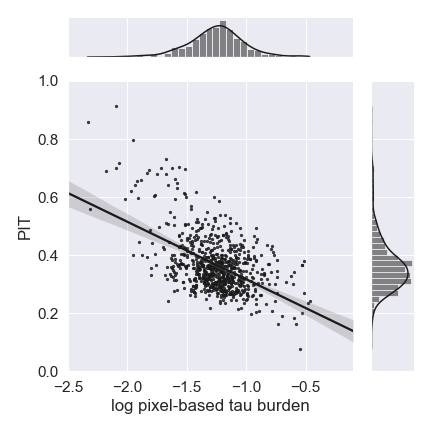

In [77]:
df6 = df5.copy()
# df6['log_regional_somatic_ratio'] = np.log10(df6['regional_somatic_ratio'])
df6['log_regional_tau_burden'] = np.log10(df6['regional_tau_burden'])
df6.to_csv('tau_stain_R.csv', index=False)
sns.set(font_scale=1.4)
g = sns.JointGrid(data=df6, x="log_regional_tau_burden", y="regional_somatic_ratio",  height=6)
ax = g.ax_joint
ax.set_ylim([0,1])
ax.set_xlim([-2.5,-0.1])
g.plot_joint(sns.regplot, truncate=False, color='k', scatter_kws={'s':5})
g.plot_marginals(sns.histplot, kde=True, color='k')
ax.set_ylabel('PIT')
ax.set_xlabel('log pixel-based tau burden')
plt.tight_layout()
sns.despine()
# plt.savefig('illustrations/pit_vs_burden.pdf')

<center>SFigure 5C</center>

In [78]:
%%R -o s1,s2,s3
fit8.3 <- brm(regional_somatic_ratio ~ diagnostic + (1|subregion_name)  + (1|Patient_ID), 
              data = stain,
              prior = prior2,
              warmup = 1e3,
              iter = 1.1e4,
              chains = 4, 
              cores = 4,
              seed = 1234,
              save_all_pars = T)
s1 <- bayes_factor(fit8, fit8.3)
s2 <- bayes_factor(fit8, fit8.3)
s3 <- bayes_factor(fit8, fit8.3)

In [79]:
for (_, v1), (_, v2), (_, v3) in zip(s1.items(), s2.items(), s3.items()):
    print('BF: {}'.format(np.asarray([v1,v2,v3]).flatten()))
    break

BF: [4.44367244e+59 4.52601464e+59 4.46944150e+59]


Bayes factor suggests extremely strong evidence (BF > 1000, mean of 3 runs) of the alternative hypothesis: log pixel-based tau burden has an effect on PIT. It inversely correlated with PIT as shown in the graph.

* It indicates tau accumulation initially happens intracellularly before moving to the extracellular space.

MRI/PET - low resolution, less quantitative